<a href="https://colab.research.google.com/github/jjungmini/solar/blob/main/BERTopic_TMLAB_0914.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필요한 라이브러리 설치
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00
  Preparing metadata (s

In [2]:
import pandas as pd
import numpy as np
import re
from bertopic import BERTopic
from bertopic import _utils
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
import matplotlib.pyplot as plt

In [43]:
# 엑셀 파일을 pandas DataFrame으로 읽어옵니다
data = pd.read_excel('marine_0921.xlsx')

# NaN 값을 제거하거나 특정 값으로 대체합니다
data['Abstract'].fillna('', inplace=True)
data['Claims'].fillna('', inplace=True)

# 데이터를 문자열로 변환
data['Abstract'] = data['Abstract'].astype(str)
data['Claims'] = data['Claims'].astype(str)

# "publication date" 열에서 날짜 정보를 추출하여 리스트로 만듭니다
data['Publication Date'] = pd.to_datetime(data['Publication Date'], errors='coerce')

# 유효한 날짜 데이터만 남기고 NaN 값을 제거합니다
data = data.dropna(subset=['Publication Date'])

# "publication date" 열이 2022년 12월 31일 이전인 데이터만 필터링합니다
filtered_data = data[data['Publication Date'] <= '2022-12-31']

# 문장 쌍을 병합하여 하나의 텍스트로 만듭니다
docs = filtered_data['Abstract'] + ' ' + filtered_data['Claims']

In [44]:
# docs: 텍스트 데이터 리스트 또는 배열

# Vectorization model (CountVectorizer) 설정
vectorizer_model = CountVectorizer(stop_words="english")

#정규표현식으로 별 관련없는 단어들을 제거하기 위한 패턴 생성
stop_words_pattern = re.compile(r'\b(claims|claim|said|according|method|selected|preferably)\w*\b', flags=re.IGNORECASE)

#텍스트 데이터에서 관련없는 단어를 제거하고, 나머지 단어로 구성된 리스트 생성
docs = [" ".join([word for word in re.split(r'\W+',doc)if not stop_words_pattern.match(word)])for doc in docs]

# Class TF-IDF 모델 설정
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# 키워드를 최대한 다양하게 하고싶을때
representation_model = MaximalMarginalRelevance(diversity=0.2)
# 주요 키워드 위주로 하고싶을때
#representation_model = KeyBERTInspired()

# BERTopic 모델을 초기화하고 토픽 모델링 수행 (토픽은 10개로 만들기 위해 nr_topics=11로 세팅)
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics=11, verbose=True)

# 토픽 모델링 수행
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/112 [00:00<?, ?it/s]

2023-09-21 15:17:47,832 - BERTopic - Transformed documents to Embeddings
2023-09-21 15:18:11,954 - BERTopic - Reduced dimensionality
2023-09-21 15:18:12,097 - BERTopic - Clustered reduced embeddings
2023-09-21 15:18:27,482 - BERTopic - Reduced number of topics from 58 to 11


In [54]:
# 토픽 빈도 출력
topic_freq = topic_model.get_topic_freq()
print(topic_freq)

    Topic  Count
3      -1   1494
0       0   1169
2       1    410
6       2    135
4       3    119
8       4     90
7       5     77
1       6     32
9       7     24
5       8     23
10      9     11


In [55]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1494,-1_comprising_process_biomass_comprises,"[comprising, process, biomass, comprises, acid...",[Abstract The present invention relates to a p...
1,0,1169,0_process_gas_biomass_comprising,"[process, gas, biomass, comprising, reactor, c...",[Abstract The present invention provides an im...
2,1,410,1_composition_acid_comprising_id,"[composition, acid, comprising, id, seq, micro...",[Abstract The invention relates to suitable sc...
3,2,135,2_light_photobioreactor_culture_photosynthetic,"[light, photobioreactor, culture, photosynthet...",[Abstract This invention provides and devices ...
4,3,119,3_data_energy_power_heat,"[data, energy, power, heat, plurality, device,...",[Abstract The invention relates to a hybrid po...
5,4,90,4_plant_seq_id_sequence,"[plant, seq, id, sequence, increased, yield, n...",[Abstract Plants having one or more enhanced y...
6,5,77,5_resin_composition_adhesive_polyol,"[resin, composition, adhesive, polyol, group, ...",[Abstract A polylactic acid acrylonitrile buta...
7,6,32,6_cannabis_solvent_cannabinoids_cannabinoid,"[cannabis, solvent, cannabinoids, cannabinoid,...",[Abstract A of preparing a water soluble or wa...
8,7,24,7_absorbent_amine_solution_piperazine,"[absorbent, amine, solution, piperazine, propa...",[Abstract The invention relates to an absorben...
9,8,23,8_graphene_carbon_membrane_material,"[graphene, carbon, membrane, material, composi...",[Abstract Perforated graphene sheets can be us...


In [56]:
# 특정 토픽의 단어들을 출력
topic_words = topic_model.get_topic(2)
formatted_topic_words = '\n'.join([f"{word}: {score}" for word, score in topic_words])
print(formatted_topic_words)

light: 0.0658771615653046
photobioreactor: 0.03984297169005942
culture: 0.03449665503275778
photosynthetic: 0.028284938339840256
comprising: 0.026816794301637928
microalgae: 0.026564828987688388
medium: 0.025270676185510668
comprises: 0.02364026120507302
mutant: 0.022935721870764352
algal: 0.02243864512280753


In [57]:
topic_model.visualize_barchart(top_n_topics=99, n_words=9) #, width=650

In [59]:
# 토픽 시각화
topic_model.visualize_topics() #topics=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

In [60]:
# 토픽 계층 시각화
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 9/9 [00:00<00:00, 94.18it/s]


In [61]:
# 토픽 문서 시각화 (쫌 오래걸림)
topic_model.visualize_hierarchical_documents(docs, hierarchical_topics)

KeyboardInterrupt: ignored

In [62]:
# 토픽 히트맵 시각화
topic_model.visualize_heatmap()

In [63]:
#term score decline
topic_model.visualize_term_rank()

In [64]:
#term score decline (log scale)
topic_model.visualize_term_rank(log_scale=True)

In [65]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(docs[1], topic_token_distr[1])
df

100%|██████████| 4/4 [01:21<00:00, 20.44s/it]


,Abstract,for,extracting,and,concentrating,cannabinoids,using,ultrasound,enhanced,solvent,extraction,Freshly,harvested,cannabis,plant,materials,which,may,be,selectively,chosen,plant,parts,or,the,entire,plant,itself,are,shredded,to,particular,particle,size,The,plant,material,is,then,mixed,with,solvent,to,form,slurry,and,thereafter,subjected,to,ultrasound,to,release,intracellular,contents,into,the,solvent,Filtering,steps,are,then,applied,to,remove,biomass,waxes,and,chlorophyll,Water,removal,and,solvent,recovery,steps,are,further,applied,to,ultimately


In [66]:
# To visualize the topic distributions in a document
topic_model.visualize_distribution(topic_distr[0])

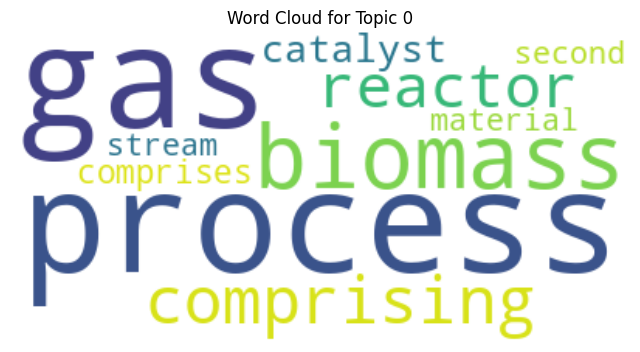

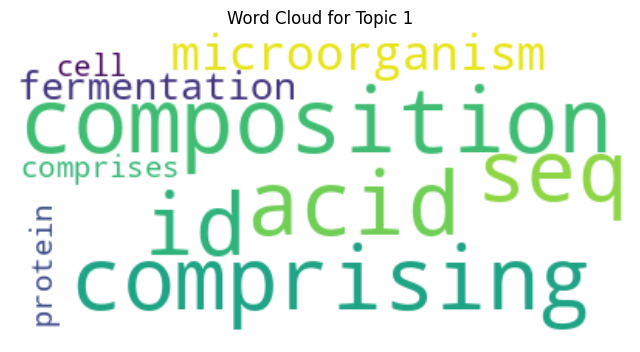

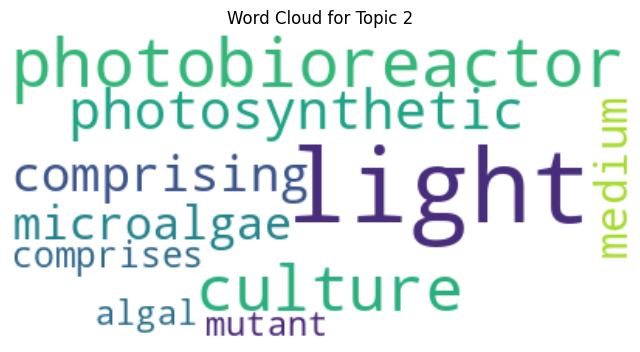

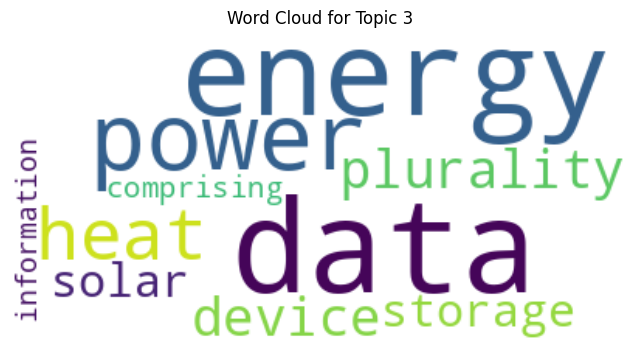

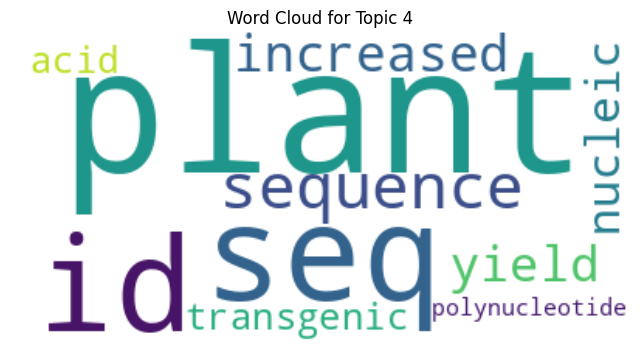

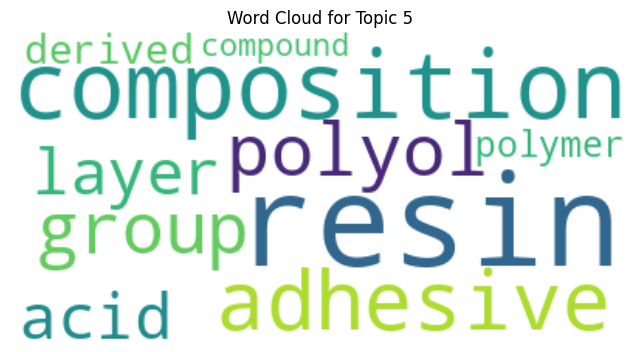

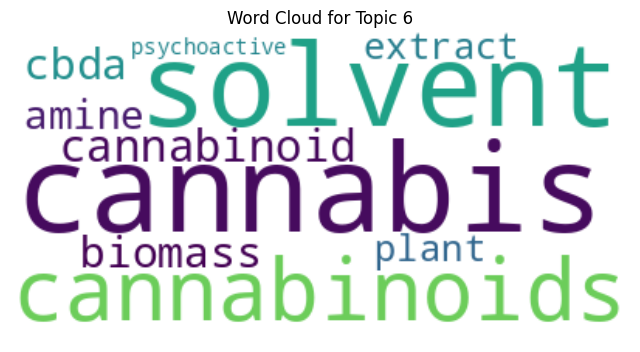

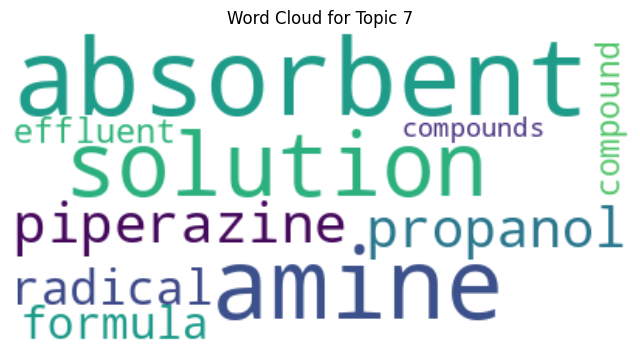

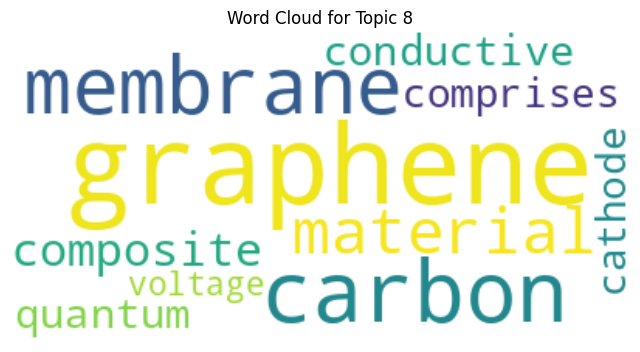

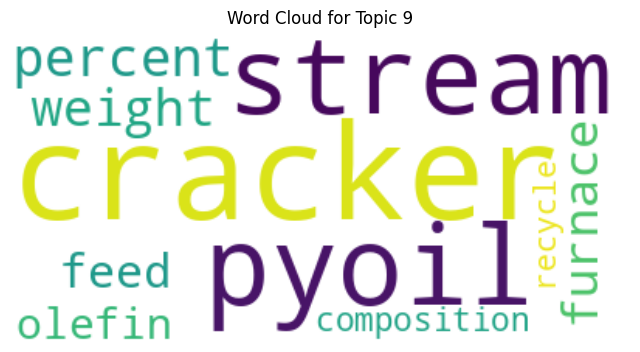

TypeError: ignored

In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic}")
    plt.show()

# Show wordclouds for all topics
for topic in range(len(topic_model.get_topics())):
    create_wordcloud(topic_model, topic=topic)

In [69]:
data.head()

,Unnamed: 0,ID,Title,Abstract,Description,Claims,Inventors,Current Assignee,Patent Office,Publication Date,...,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
2,6,WO-2019157336-A1,Simultaneous fracturing process,Abstract\n\nA method for extracting a natural ...,NaN,Claims\n\nCLAIMS What is claimed is: \n\n 1. A...,Michael KRAYNEK,Crestone Peak Resources,NaN,2019-08-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,7,WO-2019156931-A1,Method for extracting compositions from plants,Abstract\n\nMethods for extracting and concent...,NaN,Claims\n\nWHAT IS CLAIMED IS: \n\n 1. A method...,"Mark T. Cullen, Anthony J. Durkacz",World Class Extractions Inc.,NaN,2019-08-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,8,WO-2017165244-A1,Microorganisms and artificial ecosystems for t...,Abstract\n\nMicroorganisms and bioprocesses ar...,NaN,Claims\n\nCLAIMS We claim: \n\n1. A biologica...,"John S. Reed, Jil GELLER, Sonali HANDE","Kiverdi, Inc.",NaN,2017-09-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
5,9,WO-2014200598-A2,Conversion of carbon dioxide utilizing chemoau...,Abstract\n\nMethods and systems to achieve cle...,NaN,Claims\n\n\n \nclaimed is: \n A method of biol...,"Karen E. WAWROUSEK, Patrick Richards, Tengyan ...",The University Of Wyoming Research Corporation,NaN,2014-12-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
6,10,WO-2021108745-A1,"An optimized load shaping system, method & app...","Abstract\n\nA method, system and apparatus are...",NaN,Claims\n\nim: \n\n1. An optimized load shaping...,Robert F. Cruickshank Iii,Cruickshank Iii Robert F,NaN,2021-06-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


<Figure size 1500x2000 with 0 Axes>

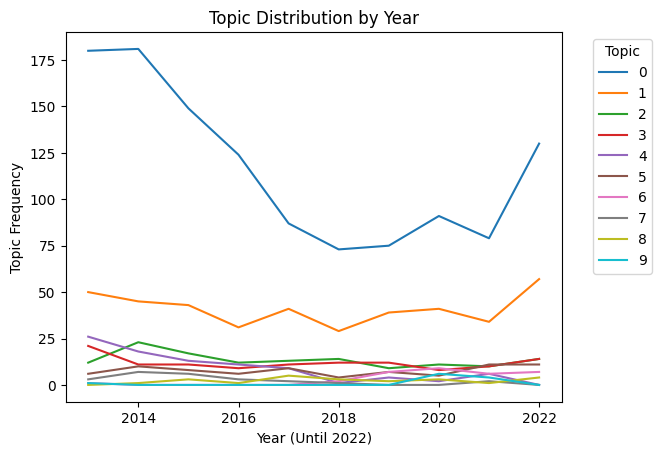

In [70]:
# "publication date" 컬럼에서 연도 정보를 추출하여 리스트로 만듭니다
data['Publication Date'] = pd.to_datetime(data['Publication Date'])
filtered_data = data[data['Publication Date'] <= '2022-12-31']
years = filtered_data['Publication Date'].dt.year.tolist()

# 토픽 및 연도를 묶어서 데이터프레임 생성
min_length = min(len(topics), len(years))
topic_df = pd.DataFrame({'Topic': topics[:min_length], 'Year': years[:min_length]})
# Topic 0을 제외한 행을 필터링한 데이터프레임을 만듭니다
filtered_topic_df = topic_df[(topic_df['Topic'] != -1)]

# 연도별 토픽 분포를 계산합니다
topic_distribution_by_year = filtered_topic_df.groupby(['Year', 'Topic']).size().unstack(fill_value=0)


# 시각화
plt.figure(figsize=(15, 20))
topic_distribution_by_year[topic_distribution_by_year.index <= 2022].plot(kind='line')
plt.xlabel('Year (Until 2022)')
plt.ylabel('Topic Frequency')
plt.title('Topic Distribution by Year')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [71]:
#모델 저장하기
topic_model.save("my_topics_model_안정민_0921")